In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image
import os
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

2025-04-10 23:44:24.858037: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 23:44:24.871092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744321464.882999   20523 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744321464.886380   20523 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744321464.899398   20523 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Devices available:", tf.config.list_physical_devices())

TensorFlow version: 2.19.0
Num GPUs Available:  1
Devices available: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


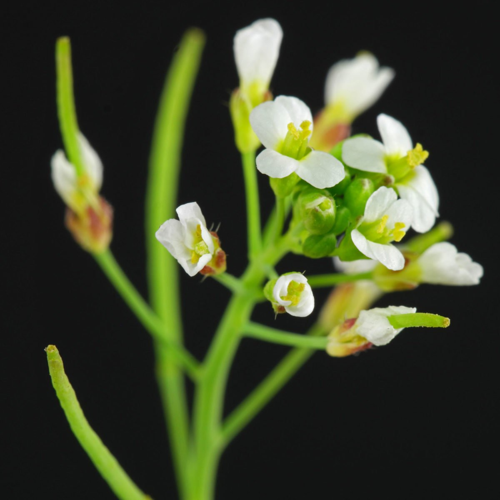

In [3]:
url = "https://pflanzenbestimmung.info/wp-content/uploads/2021/04/Arabidopsis-thaliana-4-1200x1200.jpg"

def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)

In [4]:
names = ['mixed9', 'mixed10']

# Create the standard model
print("Setting up standard InceptionV3 model...")
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
standard_layers = [base_model.get_layer(name).output for name in names]
dream_model_standard = tf.keras.Model(inputs=base_model.input, outputs=standard_layers)

# Create the fine-tuned model
print("\nSetting up fine-tuned model...")
model_path = 'plant_finetuned_inceptionv3.h5'
fine_tuned_model = load_model(model_path)

# Print all layers to debug
print("\nFine-tuned model layer structure:")
for i, layer in enumerate(fine_tuned_model.layers):
    print(f"{i}: {layer.name} - {type(layer).__name__}")
    
    # If this is a nested model, check for mixed layers inside it
    if isinstance(layer, tf.keras.models.Model):
        print(f"  Found nested model: {layer.name}")
        for j, nested_layer in enumerate(layer.layers):
            if 'mixed' in nested_layer.name:
                print(f"  {j}: {nested_layer.name}")

# Try to find InceptionV3 base model inside the fine-tuned model
base_model_in_finetuned = None
for layer in fine_tuned_model.layers:
    if isinstance(layer, tf.keras.models.Model):
        base_model_in_finetuned = layer
        print(f"Found base model: {layer.name}")
        break

Setting up standard InceptionV3 model...


I0000 00:00:1744321466.397163   20523 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13512 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9



Setting up fine-tuned model...



Fine-tuned model layer structure:
0: input_layer_1 - InputLayer
1: conv2d_94 - Conv2D
2: batch_normalization_94 - BatchNormalization
3: activation_94 - Activation
4: conv2d_95 - Conv2D
5: batch_normalization_95 - BatchNormalization
6: activation_95 - Activation
7: conv2d_96 - Conv2D
8: batch_normalization_96 - BatchNormalization
9: activation_96 - Activation
10: max_pooling2d_4 - MaxPooling2D
11: conv2d_97 - Conv2D
12: batch_normalization_97 - BatchNormalization
13: activation_97 - Activation
14: conv2d_98 - Conv2D
15: batch_normalization_98 - BatchNormalization
16: activation_98 - Activation
17: max_pooling2d_5 - MaxPooling2D
18: conv2d_102 - Conv2D
19: batch_normalization_102 - BatchNormalization
20: activation_102 - Activation
21: conv2d_100 - Conv2D
22: conv2d_103 - Conv2D
23: batch_normalization_100 - BatchNormalization
24: batch_normalization_103 - BatchNormalization
25: activation_100 - Activation
26: activation_103 - Activation
27: average_pooling2d_9 - AveragePooling2D
28: co

In [5]:
# Create fine-tuned dream model
if base_model_in_finetuned:
    # Try to get layers from the nested base model
    fine_tuned_layers = []
    for name in names:
        try:
            layer = base_model_in_finetuned.get_layer(name)
            fine_tuned_layers.append(layer.output)
            print(f"Found layer '{name}' in nested model")
        except:
            print(f"Could not find layer '{name}' in nested model")
    
    if fine_tuned_layers:
        dream_model_finetuned = tf.keras.Model(inputs=fine_tuned_model.input, outputs=fine_tuned_layers)
    else:
        print("Could not find any target layers in nested model, falling back to standard InceptionV3")
        dream_model_finetuned = dream_model_standard
else:
    # Try to get layers directly from the fine-tuned model
    print("No nested model found, trying direct layer access")
    try:
        fine_tuned_layers = [fine_tuned_model.get_layer(name).output for name in names]
        dream_model_finetuned = tf.keras.Model(inputs=fine_tuned_model.input, outputs=fine_tuned_layers)
    except Exception as e:
        print(f"Error creating fine-tuned dream model: {e}")
        print("Using standard InceptionV3 as fallback")
        dream_model_finetuned = dream_model_standard


No nested model found, trying direct layer access


In [6]:
def calc_loss(img, model):
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return tf.reduce_sum(losses)

def random_roll(img, maxroll):
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[2], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, img_size, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)

    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_size[1], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_size[0], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients

In [7]:
def run_deep_dream_with_octaves(img, model, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3, model_name=""):
  base_shape = tf.shape(img)
  img = tf.keras.utils.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  
  # Create tiled gradients for the specific model
  get_tiled_gradients = TiledGradients(model)
  
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    new_size = tf.cast(new_size, tf.int32)
    img = tf.image.resize(img, new_size)

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img, new_size)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print(f"Model: {model_name}, Octave {octave}, Step {step}")

  result = deprocess(img)
  return result

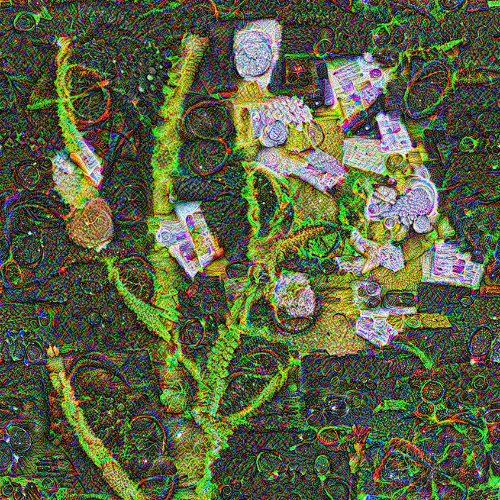

Plant fine-tuned model result

Side-by-side comparison:


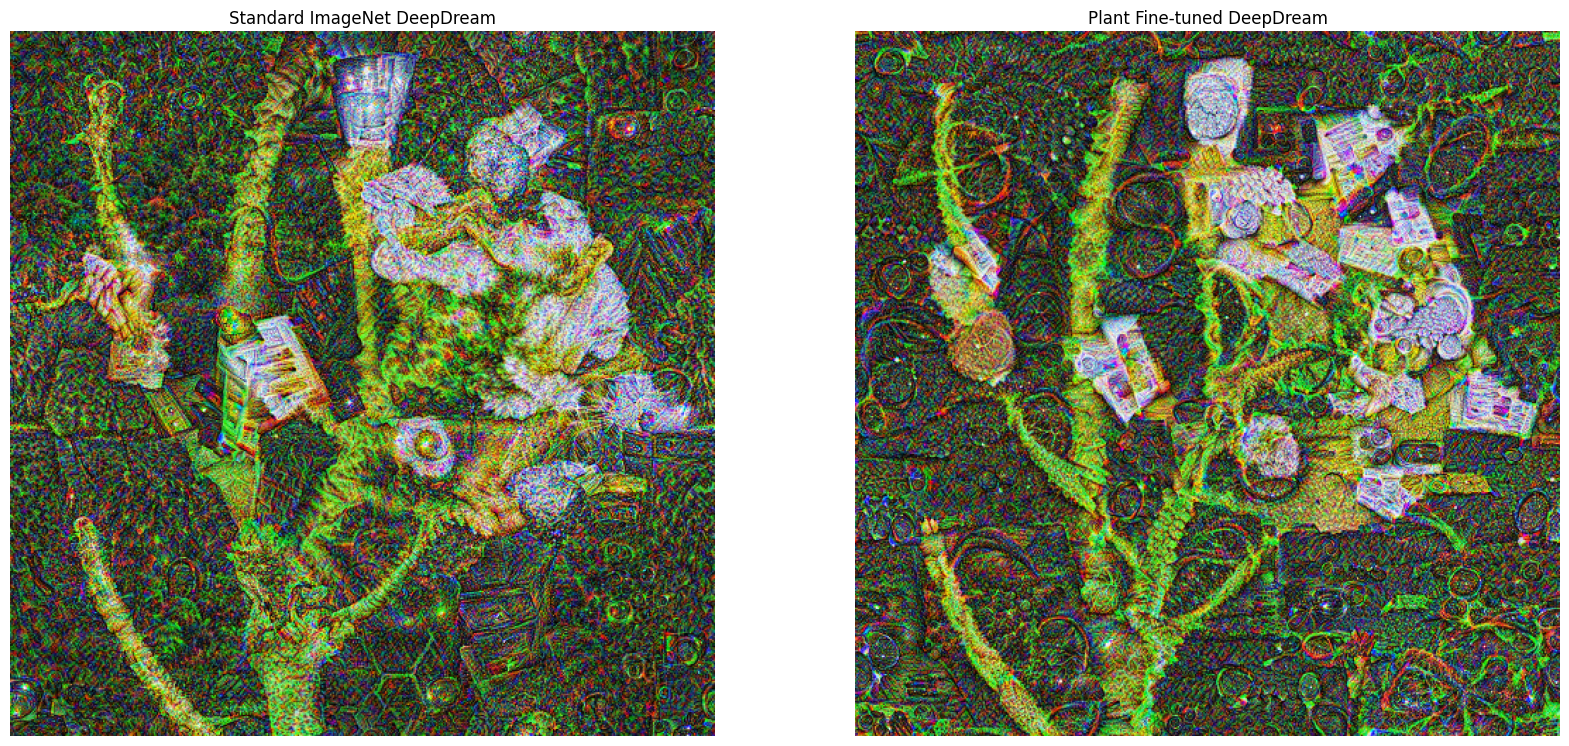

In [10]:
# Run DeepDream with standard ImageNet model
print("\nRunning DeepDream with standard ImageNet model...")
img_standard = run_deep_dream_with_octaves(
    img=original_img,
    model=dream_model_standard,
    steps_per_octave=300,  # Reduced for faster processing
    step_size=0.02,
    octave_scale=1.3,
    model_name="Standard ImageNet"
)

# Save the standard model result
display.clear_output(wait=True)
img_standard = tf.image.resize(img_standard, tf.shape(original_img)[:-1])
img_standard = tf.image.convert_image_dtype(img_standard/255.0, dtype=tf.uint8)
show(img_standard)
print("Standard ImageNet model result")
PIL.Image.fromarray(np.array(img_standard)).save('standard_model_dream.jpg')

# Run DeepDream with fine-tuned model
print("\nRunning DeepDream with plant fine-tuned model...")
img_finetuned = run_deep_dream_with_octaves(
    img=original_img,
    model=dream_model_finetuned,
    steps_per_octave=300,  # Reduced for faster processing
    step_size=0.02,
    octave_scale=1.3,
    model_name="Plant Fine-tuned"
)

# Save the fine-tuned model result
display.clear_output(wait=True)
img_finetuned = tf.image.resize(img_finetuned, tf.shape(original_img)[:-1])
img_finetuned = tf.image.convert_image_dtype(img_finetuned/255.0, dtype=tf.uint8)
show(img_finetuned)
print("Plant fine-tuned model result")
PIL.Image.fromarray(np.array(img_finetuned)).save('finetuned_model_dream.jpg')

# Display both side by side for comparison
print("\nSide-by-side comparison:")
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(np.array(img_standard))
plt.title("Standard ImageNet DeepDream")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.array(img_finetuned))
plt.title("Plant Fine-tuned DeepDream")
plt.axis('off')
plt.show()